<a href="https://www.kaggle.com/code/aicortex/memory-matters-optimizing-ml-pipelines?scriptVersionId=211013592" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="font-family: Arial, sans-serif; background-color: #f9f9f9; color: #333; line-height: 1.6; width: 100%; margin: 0; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">

  <h1 style="color: #4caf50; text-align: center; font-size: 2.4em; margin-bottom: 10px;">🚀 Welcome to the Pipeline Optimization Notebook! 🚀</h1>
  
  <p style="font-size: 1.2em;">In this notebook, we’ll explore the power of <span style="background-color: #ffeb3b; font-weight: bold; padding: 2px 4px; border-radius: 4px;">memory caching</span> in machine learning pipelines. By comparing pipelines with and without memory, we’ll demonstrate how caching can significantly boost efficiency. 🌟</p>

  <h2 style="color: #2196f3; font-size: 1.8em; margin-bottom: 10px;">🔍 What You’ll Learn</h2>
  
  <p style="font-size: 1.2em;">Here’s what we’ll cover:</p>
  <ul>
    <li style="font-size: 1.2em;">How to use <span style="background-color: #ffeb3b; font-weight: bold; padding: 2px 4px; border-radius: 4px;">Memory</span> in a scikit-learn pipeline.</li>
    <li style="font-size: 1.2em;">The impact of caching on cross-validation and model training.</li>
    <li style="font-size: 1.2em;">Key insights into pipeline optimization.</li>
  </ul>

  <h2 style="color: #2196f3; font-size: 1.8em; margin-bottom: 10px;">💻 Code Highlights</h2>
  
  <div style="background-color: #f4f4f4; border-left: 4px solid #2196f3; padding: 10px; margin: 10px 0; border-radius: 4px; overflow-x: auto; font-family: 'Courier New', Courier, monospace;">
    memory = Memory(location="cachedir", verbose=0)<br>
    pipeline = Pipeline(<br>
    &nbsp;&nbsp;&nbsp;&nbsp;steps=[<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;('scaler', StandardScaler()),<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;('model', RandomForestClassifier(random_state=42))<br>
    &nbsp;&nbsp;&nbsp;&nbsp;],<br>
    &nbsp;&nbsp;&nbsp;&nbsp;memory=memory<br>
    )
  </div>
  
  <p style="font-size: 1.2em;">As we proceed, we’ll analyze the logs and interpret the behavior of each pipeline step. 🔧</p>

  <div style="text-align: center; margin-top: 20px; font-size: 1.1em; color: #555;">Enjoy the journey and don’t forget to upvote if you find this helpful! ❤️</div>

</div>


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.metrics import classification_report, ConfusionMatrixDisplay


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from joblib import Memory

In [2]:
df = pd.read_csv('/kaggle/input/iris/Iris.csv')
df = df.drop('Id', axis=1)
df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
label_encoder = LabelEncoder()

X = df.drop('Species', axis=1)
y = label_encoder.fit_transform(df['Species'])

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=42,
                                                    stratify=y)

In [4]:
df['Species'].value_counts()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [5]:
def evaluate(model, X_test=X_test, y_test=y_test, labels=None):
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=labels)

In [6]:
param_grid = {'model__n_estimators': [50, 100], 
              'model__max_depth': [None, 10]}

# 🧠 Pipeline with Memory

## 🧠✨ Explanation of the Output ✨🧠

### 1️⃣ **Logs for `scaler` (Step 1 of 2):**
   ```py
   [Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
   ```
   - 🚀 The `scaler` step standardizes the features using `StandardScaler`.  
   - **It runs 3️⃣ times**:
     - 🌀 **2 times** during cross-validation because the data is split into 2 folds (each fold requires separate preprocessing).  
     - 🎯 **1 additional time** after cross-validation to preprocess the full dataset when training the final model with the best parameters.  

### 2️⃣ **Logs for `model` (Step 2 of 2):**
   ```py
   [Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
   ```
   - 🌳 The `model` step trains the `RandomForestClassifier`.  
   - **It runs 8️⃣ times**:
     - 🔧 **4 parameter combinations × 2 folds = 8 executions** during cross-validation.  

---

### 🤔 Why Does `scaler` Run 3 Times?  
- ⚡ **Cross-validation:** The data is split into 2 folds, so the scaler is applied **once per fold**.  
- 💡 **Final Model:** After finding the best hyperparameters, the scaler runs again on the full dataset to train the final model.  

---

### 🌟 Key Insight:
The `scaler` step runs **one more time than the number of folds** because it processes the full dataset for the final model training. This shows how pipelines are built to ensure both efficient preprocessing and accurate model training. ✨🔥
```

In [7]:
memory = Memory(location="I_love_kaggle", verbose=0)

pipline_1 = Pipeline(
    steps=[
        
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(random_state=42))
    ], 
    verbose=True,
    # memory=memory
)

model_1 = GridSearchCV(pipline_1,
                     param_grid,
                     n_jobs=1,  # set it None to see step by step process
                     cv=KFold(n_splits=2, random_state=42, shuffle=True),
                     verbose=1)

model_1.fit(X_train, y_train);

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .......

## 🔍 Second Execution: Observing the Difference

When the code is run **again**, the behavior changes. Here's what happens in the output:

---
#### **1️⃣ Why Doesn’t `scaler` Run?**
- The `scaler` step (`step 1 of 2`) is **not executed again** because it is cached in memory (`Memory`).  
- Since the inputs and preprocessing have not changed, the cached results are reused, avoiding unnecessary computations. 🧠✨
---

#### **2️⃣ Why Does `model` Run 9 Times?**
- The `model` step (`step 2 of 2`) **cannot be cached** because it involves training the model with different hyperparameters and data splits.
- **Breakdown of the 9 executions:**
  - 🌀 **8 times during cross-validation**: 
    - For each of the 4 hyperparameter combinations across 2 folds.
  - 🎯 **1 additional time**: 
    - After cross-validation, the model is trained on the entire dataset using the **best hyperparameters** found during the grid search.

---

### 🧠 Key Insight:
- **Caching Impact:** The caching mechanism prevents redundant execution of the `scaler` step, improving efficiency.  
- **Model Training:** The `model` step runs multiple times because it depends on the hyperparameters and cannot be cached.  
- This highlights the **balance between caching and necessary computations** in pipeline execution! 🚀🔥


In [8]:
model_1.fit(X_train, y_train);

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .......


# Pipeline Without Memory

In this example, the pipeline is run **without memory caching** (`memory=None`). Here's what happens during execution:

---

###  **1️⃣ `scaler` (Step 1 of 2):**
   ```py
   [Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
   ```
   - The `scaler` step, which standardizes the input data, runs **9 times** in total:
     - **8 times during cross-validation**:
       - For 2 folds and 4 hyperparameter combinations.
     - **1 additional time** when the best parameters are used to train the final model on the full dataset.
   - Since no caching is used, this step is recomputed every time, even though the input data remains unchanged.

---

### **2️⃣ `model` (Step 2 of 2):**
   ```py
   [Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
   ```
   - The `model` step, which trains the `RandomForestClassifier`, also runs **9 times**:
     - **8 times during cross-validation**:
       - For each fold and parameter combination.
     - **1 additional time** when the final model is trained with the best parameters on the full dataset.

---

### 🔑 Key Differences Compared to Pipeline with Memory:
1. **No Caching for `scaler`:**
   - Unlike the pipeline with memory, the `scaler` step is recomputed every time, leading to redundant processing.
   - This highlights the inefficiency of not caching repetitive preprocessing steps.

2. **Model Step Behavior Remains the Same:**
   - The `model` step cannot be cached in either case, as it must run for every combination of hyperparameters and folds.

---

### 🧠 Insight:
- Without memory, both the `scaler` and `model` steps are executed redundantly during cross-validation, leading to more computation time.
- Using memory caching can significantly improve efficiency by avoiding unnecessary recomputation of preprocessing steps like `scaler`. 🚀
```

In [9]:
pipline_2 = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(random_state=42))
    ], 
    verbose=True,
    memory=None
)

model_2 = GridSearchCV(pipline_2,
                     param_grid,
                     n_jobs=None,  # set it None to see step by step process
                     cv=KFold(n_splits=2, random_state=42, shuffle=True),
                     verbose=1)

model_2.fit(X_train, y_train);

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .......

## 🔄 Second Execution: Pipeline Without Memory

- **`scaler` (Step 1 of 2):**  
   Runs **9 times**:
   - **8 times** during cross-validation (4 combinations × 2 folds).
   - **1 time** for final training with the best parameters.

- **`model` (Step 2 of 2):**  
   Runs **9 times** for the same reasons as above.

---

### Key Insight:
Without caching, both `scaler` and `model` are recomputed every time, causing redundant computations and inefficiency. 🚀


In [10]:
model_2.fit(X_train, y_train);

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .......

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.86      0.92      0.89        13
           2       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38



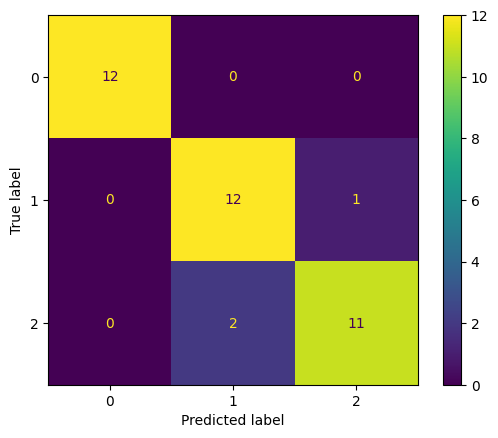

In [11]:
evaluate(model_1)

In [12]:
model_1.best_params_

{'model__max_depth': None, 'model__n_estimators': 100}

# ✅ Conclusion

Using **memory caching** in pipelines significantly reduces redundant computations, especially for preprocessing steps like `scaler`. While the `model` step still runs multiple times due to parameter tuning, caching makes the entire process more efficient.  

If you found this notebook helpful or learned something new, don’t forget to **upvote**! 🚀✨  
Your support motivates us to share more valuable insights. 🌟
